### リファレンスの確認

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, LogFormatterMathtext, NullFormatter
import spectral.io.envi as envi
from src.core import WHITE_DARK_DIR, IMAGES_DIR

In [ ]:
white_hdr = WHITE_DARK_DIR / "W.hdr"
white_raw = WHITE_DARK_DIR / "W.raw"
dark_hdr  = WHITE_DARK_DIR / "D.hdr"
dark_raw  = WHITE_DARK_DIR / "D.raw"

white = envi.open(str(white_hdr), str(white_raw))
wave = np.array(white.metadata["wavelength"], dtype=np.float32)
white = np.array(white.load(), dtype=np.float32)

dark = envi.open(str(dark_hdr), str(dark_raw))
dark = np.array(dark.load(), dtype=np.float32)

### SNR の定義

$$
\mathrm{SNR}(\lambda)
=
\frac{
\mathbb{E}_{p}\!\left[\,W(p,\lambda)-D(p,\lambda)\,\right]
}{
\sqrt{
\mathrm{Var}_{p}\!\left[\,W(p,\lambda)-D(p,\lambda)\,\right]
}
}
$$

ここで

* $\mathbb{E}_{p}[\cdot]$ は **空間方向 $p$（pixel）に関する平均**を表す
* $\mathrm{Var}_{p}[\cdot]$ は **空間方向 $p$（pixel）に関する分散**を表す
* $p$ は空間方向（pixel）
* $\lambda$ は band（波長インデックス）
* $W$ は white reference，$D$ は dark reference

すなわち，本式は **白板−暗電流信号 $(W-D)$ の空間平均を信号，空間分散をノイズとみなした band-wise SNR** を示している。

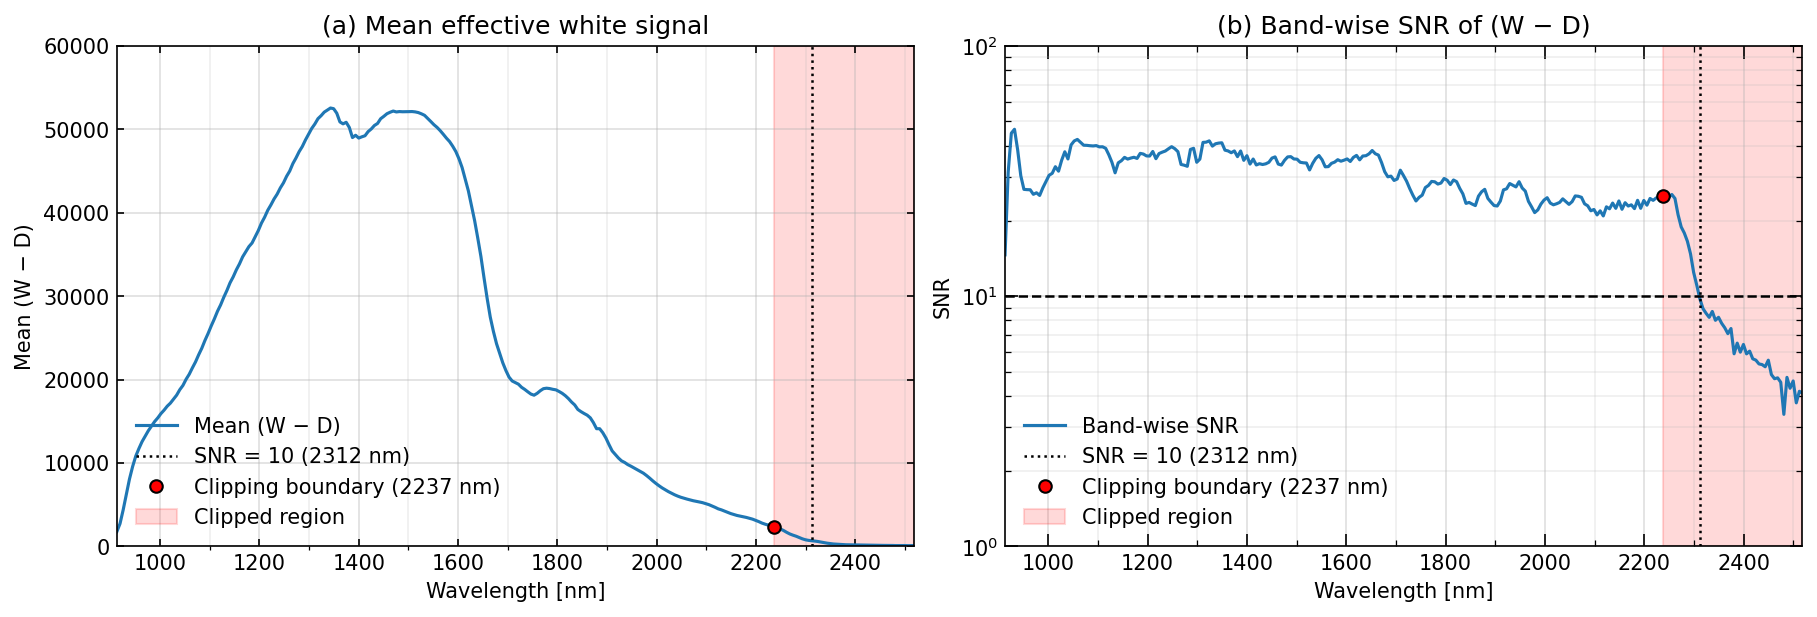

In [8]:
WD = white - dark                  # (1, 320, 256)
wd_mean = WD.mean(axis=(0, 1))     # (256,)
wd_std  = WD.std(axis=(0, 1))      # (256,)

eps = 1e-6
snr = wd_mean / (wd_std + eps)

# -------------------------
# SNR threshold crossing
# -------------------------
snr_th = 10.0
below = np.where(snr < snr_th)[0]
cut_idx = below[0] if len(below) > 0 else None

# 強調したい index（clipping boundary）
mark_idx = 210

# 対応する波長
cut_wave  = wave[cut_idx] if cut_idx is not None else None
mark_wave = wave[mark_idx]

# -------------------------
# Plot
# -------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 4),
    dpi=150,
    constrained_layout=True,
)

# nm 用 locator
major_locator = MultipleLocator(200)
minor_locator = MultipleLocator(100)

# fill 設定
fill_color = "red"
fill_alpha = 0.15

# =========================
# (a) Mean (W - D)
# =========================
ax = axes[0]
ax.plot(
    wave,
    wd_mean,
    linewidth=1.5,
    label="Mean (W − D)",
)
ax.set_xlim(wave.min(), wave.max())
ax.set_ylim(0, 60000)
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Mean (W − D)")
ax.set_title("(a) Mean effective white signal")

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_minor_locator(minor_locator)

ax.grid(True, which="major", alpha=0.4)
ax.grid(True, which="minor", alpha=0.2)
ax.tick_params(direction="in", top=True, right=True)

# SNR=10 縦線
if cut_wave is not None:
    ax.axvline(
        cut_wave,
        color="k",
        linestyle=":",
        linewidth=1.2,
        label=f"SNR = 10 ({cut_wave:.0f} nm)",
    )

# Clipping boundary（赤丸）
ax.plot(
    mark_wave,
    wd_mean[mark_idx],
    marker="o",
    markersize=6,
    markerfacecolor="red",
    markeredgecolor="black",
    linestyle="None",
    zorder=5,
    label=f"Clipping boundary ({mark_wave:.0f} nm)",
)

# --- Clipped region（右側を半透明赤で塗る）---
ax.axvspan(
    mark_wave,
    wave.max(),
    color=fill_color,
    alpha=fill_alpha,
    zorder=0,
    label="Clipped region",
)

ax.legend(frameon=False, loc="lower left")

# =========================
# (b) Band-wise SNR
# =========================
ax = axes[1]
ax.plot(
    wave,
    snr,
    linewidth=1.5,
    label="Band-wise SNR",
)
ax.set_xlim(wave.min(), wave.max())
ax.set_yscale("log")
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("SNR")
ax.set_title("(b) Band-wise SNR of (W − D)")

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_minor_locator(minor_locator)

# --- log 軸設定 ---
ax.yaxis.set_major_locator(LogLocator(base=10.0))
ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10)))
ax.yaxis.set_minor_formatter(NullFormatter())

# decade 境界調整
snr_pos = snr[np.isfinite(snr) & (snr > 0)]
kmin = int(np.floor(np.log10(snr_pos.min())))
kmax = int(np.ceil(np.log10(snr_pos.max())))
if kmax - kmin < 1:
    kmin -= 1
ax.set_ylim(10**kmin, 10**kmax)

ax.tick_params(which="major", direction="in", top=True, right=True, length=6)
ax.tick_params(which="minor", direction="in", top=True, right=True, length=3)

# SNR=10 横線
ax.axhline(
    10,
    color="k",
    linestyle="--",
    linewidth=1.2
)

# SNR=10（縦線で波長位置を示す）
if cut_wave is not None:
    ax.axvline(
        cut_wave,
        color="k",
        linestyle=":",
        linewidth=1.2,
        label=f"SNR = 10 ({cut_wave:.0f} nm)",
    )

# Clipping boundary（赤丸）
ax.plot(
    mark_wave,
    snr[mark_idx],
    marker="o",
    markersize=6,
    markerfacecolor="red",
    markeredgecolor="black",
    linestyle="None",
    zorder=5,
    label=f"Clipping boundary ({mark_wave:.0f} nm)",
)

# --- Clipped region ---
ax.axvspan(
    mark_wave,
    wave.max(),
    color=fill_color,
    alpha=fill_alpha,
    zorder=0,
    label="Clipped region"
)

ax.grid(True, which="major", alpha=0.4)
ax.grid(True, which="minor", alpha=0.2)

ax.legend(frameon=False, loc="lower left")
plt.savefig(IMAGES_DIR / "spectra" / "reference_snr.png")
plt.show()


### `01_preprocessing.py` では 2237nm 以上をclip

In [9]:
wave = np.load("data/spectra/wavenumber.npy")
print(wave.min(), wave.max())

wave_cm = 1e7/wave
print(wave_cm.min(), wave_cm.max())
print(len(wave))

913.1 2230.37
4483.5605 10951.703
210


#### MAE の学習データサイズ

In [10]:
np.load("data/train/reflectance_snv_downsampled.npy").shape

(196785, 210)